On this post I create implement a *Naive Bayes* classifier that can differentiate posts from [FML](http://www.fmylife.com) and [Just Made My Day](http://www.justmademyday.com), where the first ones are generally depressing and the second uplifting. By looking at a sample of these posts we can get some ideas for the model features.

In [6]:
import requests
import re
import urllib
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import random

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')
sns.set(style="white", font_scale=1.5)
pd.options.display.max_colwidth = 140

First we download the data from the websites. JustMadeMyDay.com only has 742 posts available, so we will limit the ones from FML to this number as well, to keep the dataset balanced.

In [88]:
## FMyLife.com data.
fml_data = []
for i in xrange(58):
    r = urllib.urlopen('http://www.fmylife.com/' + '?page=' + `i`).read()
    soup = BeautifulSoup(r, 'html.parser')
    for elem in soup.find_all('div', class_ = 'article'):
        result = re.match('(.*)(FML)' ,elem.get_text())
        if result:
            result = re.sub('Today(, )?', '', result.group(0))
            fml_data.append(result[:-4])

print '%i observations retrieved for FML.' %(len(fml_data))

728 observations retrieved for FML.


In [39]:
## JustMadeMyDay.com data.
mmd_data= []
for i in xrange(0, 1000, 500):
    r = requests.post("http://justmademyday.com/wp-content/plugins/ajaxhandler/ajaxhandler.php", \
                      data={'func': 'add', 'num': 560, 'offset': i})
    r.text.encode('utf-8')
    result = re.findall('', r.text.encode('utf-8'))
    result = [re.sub('<(/)?h1>', '', w) for w in result]
    result = [re.sub('just made my day', '--', w) for w in result]
    mmd_data.extend(result)
    
print '%i observations retrieved for JMMD.' %(len(mmd_data))

736 observations retrieved for JMMD.


Now let's look at the data. Below are 5 sample posts from each source; notice we removed both *FML* and *just made my day* strings from them, since they provide too much information for our classifier.

In [97]:
random.seed(39)
print 'FML posts:'
for line in random.sample(fml_data,5):
    print '* ' + line
    
print '\nJust Made My Day posts:'
for line in random.sample(mmd_data,5):
    print '* ' + line

FML posts:
* my boyfriend told me he only loves me sometimes. He explained what days he chooses to love me and what days he doesn't want to. I told him that's not how it works. He disagreed. He's 27. He still doesn't understand why this is a problem.
* eight tornados hit the town where I live. The only person who tried to get a hold of me and see if I was OK was my World of Warcraft guild leader after I didn't show up to raid.
* I found nudes on my boyfriend's phone. We've been together 14 years. They weren't of me.
* I woke up to my husband's face. That'd be nice if he hadn't turned his eyelids inside out, waiting to scare me. I was scared alright. So scared that I pissed myself and broke my side table falling out of bed.
* after calling my bank to see where my paycheck was, and waiting on hold for my entire lunch break, my boss told me she forgot to submit my deposit. I was relying on that money to pay for lunch today as I used all I had for bills. Looks like I eat tomorrow.

Just Ma

Thinking in terms of features for the model, we see some interesting distinctions:
- FML posts are long winded and tend to tell a complete story. On the other hand JMMD entires are relatively short and simplistic.
- JMMD posts tend to finish with an exclamation mark (!).
- FML posts contain words with negative polarity, JMMD positive ones.

We will derive features based on these observations. But before that, another interesting thing to look at is at the most popular words by relative frequency; which appear most in one of the sources and is very rare on the other. We focus specifically on nouns and verbs.

In [41]:
## Load required libraries.
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from afinn import Afinn
from collections import Counter 
afinn = Afinn()

In [98]:
## Get counts of all non-stopwords.
fml_tkns = [word_tokenize(l) for l in fml_data]
mmd_tkns = [word_tokenize(l) for l in mmd_data]

fml_bag = [t.lower() for sent in fml_tkns for t in sent if t.lower() not in stopwords.words('english') \
           if re.match('\w+', t) if re.match('\D+', t)]
mmd_bag = [t.lower() for sent in mmd_tkns for t in sent if t.lower() not in stopwords.words('english') \
           if re.match('\w+', t) if re.match('\D+', t)]

fml_counts = Counter(fml_bag)
mmd_counts = Counter(mmd_bag)

## Covert to relative frequency.
for elem in fml_counts.most_common():
    if mmd_counts[elem] != 0:
        fml_counts[elem] = fml_counts[elem]/mmd_counts[elem] 
        
for elem in fml_counts.most_common():
    if fml_counts[elem] != 0:
        mmd_counts[elem] = mmd_counts[elem]/fml_counts[elem] 

word_freq = pd.DataFrame({'word':[word[0] for word in fml_counts.most_common(20)] + \
                                  [word[0] for word in mmd_counts.most_common(20)],
                          'count':[word[1] for word in fml_counts.most_common(20)] + \
                                  [word[1] for word in mmd_counts.most_common(20)],
                          'source':['FML'] * 20 + ['MMD'] * 20
                          })

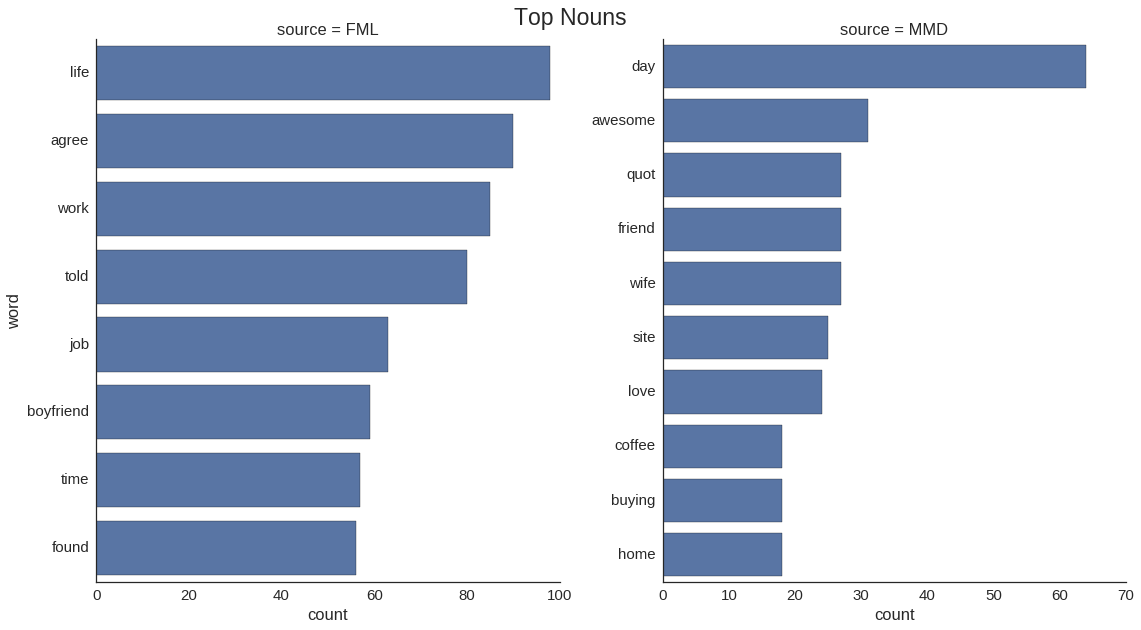

In [99]:
## Plot top nouns.
for i, row in word_freq.iterrows():
    word_freq.loc[i, 'pos'] = nltk.pos_tag([row['word']])[0][1][:2]

nn_freq = word_freq[word_freq.pos == 'NN']
g = sns.FacetGrid(nn_freq, col='source', sharex=False, sharey=False, size=9, aspect=.9)
g.map(sns.barplot, 'count', 'word')

plt.subplots_adjust(top=0.93)
g.fig.suptitle('Top Nouns', fontsize=23);

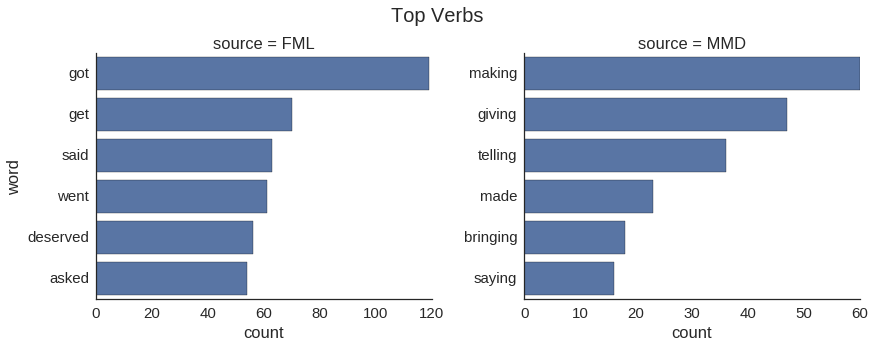

In [100]:
## Plot top verbs.
vb_freq = word_freq[word_freq.pos == 'VB']
g = sns.FacetGrid(vb_freq, col='source', sharex=False, sharey=False, size=5, aspect=1.25)
g.map(sns.barplot, 'count', 'word')
#5DBCD2'
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Top Verbs', fontsize=20);

It seems that the negative experiences from FML are associated with work, relationships, and life in general. On the other hand, coffee, friends, home and buying are factors that can make your day. In terms of verbs, *getting what you deserve* seems to be a negative experience, while making, giving, bringing and talking are associated with positive things. 

## Training the Model

Now we proceed to derive features and the Naive Bayes classifier. Based on our previous observations, our features will be:
- Polarity of words in posts, as defined by the Afinn lexicon. We look specifically at nouns and adjectives, since these POS tend to contain the most information.
- Counts of words in post.
- Counts of exclamation marks in post.

In [101]:
## Get features.
fml_pos = nltk.pos_tag_sents(fml_tkns)
fml_len = [len(l) for l in fml_tkns]
fml_exc = [l.count('!') for l in fml_tkns]
fml_class = [0] * len(fml_tkns)

mmd_pos = nltk.pos_tag_sents(mmd_tkns)
mmd_len = [len(l) for l in mmd_tkns]
mmd_exc = [l.count('!') for l in mmd_tkns]
mmd_class = [1] * len(mmd_tkns)

In [102]:
## Get word polarity (FML).
fml_key = [] 
fml_sent = []

for i in xrange(len(fml_tkns)):
    nl = []
    for e in xrange(len(fml_tkns[i])):
        if (fml_pos[i][e][1].startswith('JJ')) or (fml_pos[i][e][1].startswith('RB')):
            nl.append(fml_pos[i][e][0])
    fml_key.append(nl)
    fml_sent.append(sum([afinn.score(w) for w in fml_key[i]]))
    
print 'The average sentiment on FML is %f.' %np.mean(fml_sent)

The average sentiment on FML is 0.090659.


In [103]:
## Get word polarity (JMMD).
mmd_key = [] 
mmd_sent = []

for i in xrange(len(mmd_tkns)):
    nl = []
    for e in xrange(len(mmd_tkns[i])):
        if (mmd_pos[i][e][1].startswith('JJ')) or (mmd_pos[i][e][1].startswith('RB')):
            nl.append(mmd_pos[i][e][0])
    mmd_key.append(nl)
    mmd_sent.append(sum([afinn.score(w) for w in mmd_key[i]]))

print 'The average sentiment on JMMD is %f.' %np.mean(mmd_sent)

The average sentiment on JMMD is 0.788043.


In [104]:
## Make dataframe and divide into training and test.
df = pd.DataFrame({'sent' : fml_sent + mmd_sent, 
                   'len' : fml_len + mmd_len,
                   'exc' : fml_exc + mmd_exc,
                   'class' : fml_class + mmd_class})

msk2 = np.random.rand(len(df)) < 0.8
train2 = df[msk2]
test2 = df[~msk2]

Below, a quick visualization of the features' distribution.

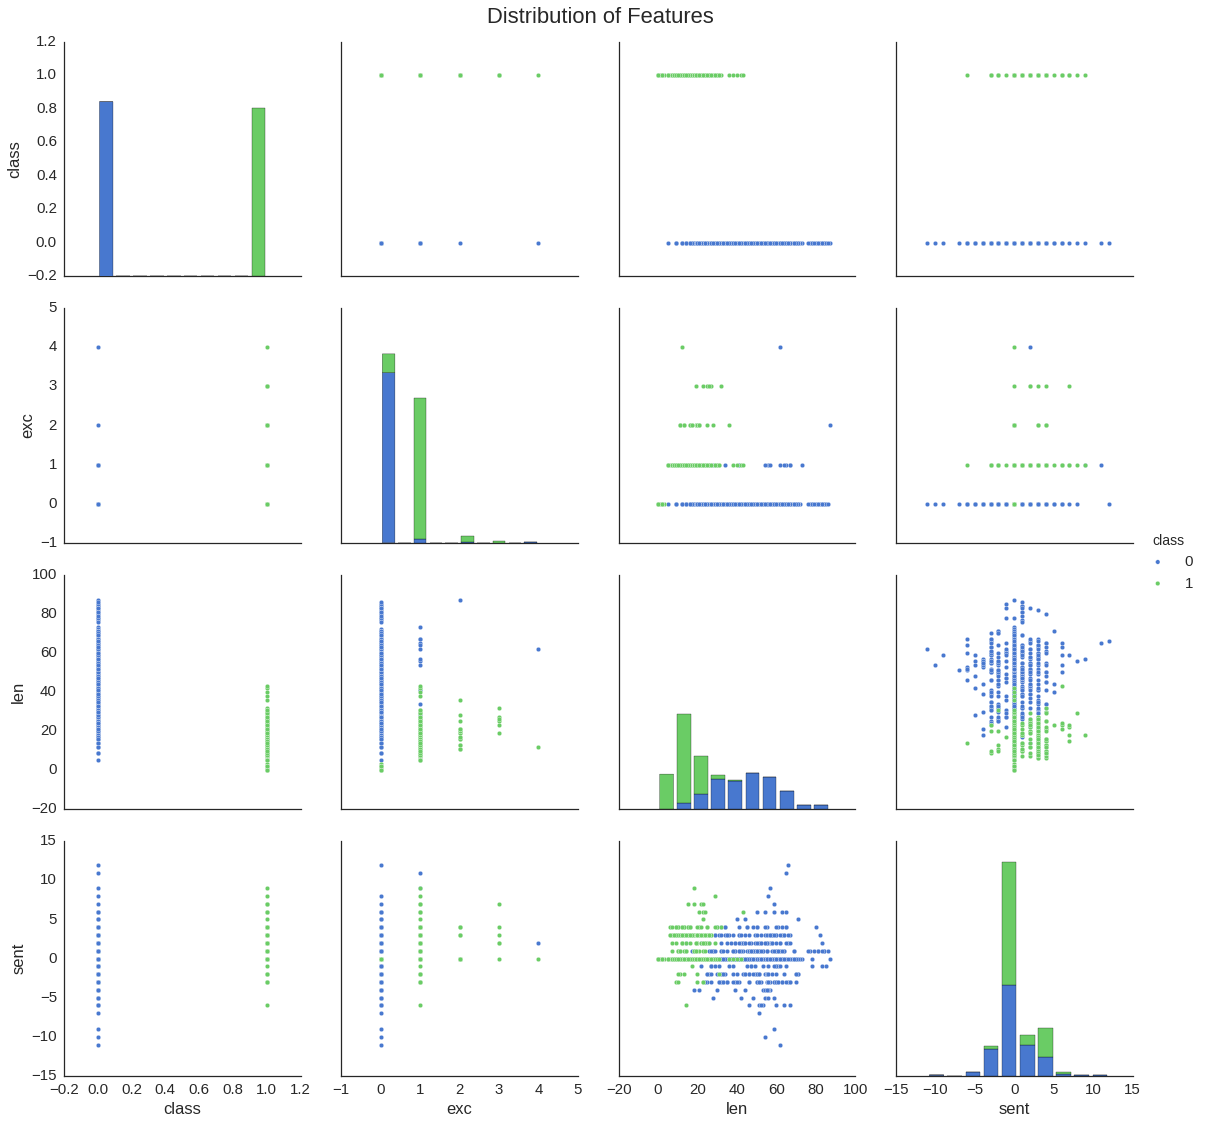

In [105]:
sns.pairplot(train2, hue='class', palette='muted', size=4);
plt.subplots_adjust(top=0.95)
plt.suptitle('Distribution of Features', fontsize=22);

In [108]:
## Train the model and test its accuracy.
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(train2[['sent', 'len', 'exc']], train2['class'])

print "TRAINING SET"
print('Accuracy Rate: %.4f \n' % gnb.score(train2[['sent', 'len', 'exc']], train2['class']))

print "TEST SET"
print('Accuracy Rate: %.4f' % gnb.score(test2[['sent', 'len', 'exc']], test2['class']))

TRAINING SET
Accuracy Rate: 0.9846 

TEST SET
Accuracy Rate: 0.9932


The accuracy is surprisingly high, meaning that our features were well selected. Let's take a look at some of the instances where we made mistakes.

In [107]:
errors = test2[gnb.predict(test2[['sent', 'len', 'exc']]) != test2['class']].index
pd.DataFrame({'line':fml_data + mmd_data}).ix[errors]

,line
176,my girlfriend told me that she didn't know we were actually dating.
401,"I was told I'll need a hysterectomy. I'm barely 22. My doctor said ""You probably wanted kids, huh? That's gonna be rough!"""


These are clearly posts from FML, but its easy to see why the classifier made mistakes on them: they are relatively short sentences, with words without much polarity. 